# Construct Pre-1979 IVs for 14-Year-Sequence Sample

*Note: 14-year-sample IVs are used as part of multiple imputation, but not in regression models.*

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
# helper functions

def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


## Convert between calendar date and continuous weeks

In [3]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_r26.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [4]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = df[(df['Week Start:\nMonth']==month)&(df['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])
    
    
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = df[df['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

## Retrieve 14-year-seq sample

In [5]:
# read sample data files
analytic_df = pd.read_csv("../data/analytic_df_seq14.csv")
print analytic_df.shape
print analytic_df.columns

(3688, 99)
Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd', u'c4dob_m_xrnd',
       u'c4dob_y_xrnd', u'c5dob_m_xrnd', u'c5dob_y_xrnd', u'c6dob_m_xrnd',
       u'c6dob_y_xrnd', u'c7dob_m_xrnd', u'c7dob_y_xrnd', u'c8dob_m_xrnd',
       u'c8dob_y_xrnd', u'c9dob_m_xrnd', u'c9dob_y_xrnd', u'c10dob_m_xrnd',
       u'c10dob_y_xrnd', u'c11dob_m_xrnd', u'c11dob_y_xrnd', u'y_dob',
       u'm_dob', u'date_m_1979', u'date_d_1979', u'date_m_1980',
       u'date_d_1980', u'date_m_1981', u'date_d_1981', u'date_m_1982',
       u'date_d_1982', u'date_m_1983', u'date_d_1983', u'date_m_1984',
       u'date_d_1984', u'date_m_1985', u'date_d_1985', u'date_m_1986',
       u'date_d_1986', u'date_m_1987', u'date_d_1987', u'date_m_1988',
       u'date_d_1988', u'date_m_1989', u'date_d_1989', u'date_m_1990',
       u'date_d_1990', u'date_m_1991', u'date_d_1991', u

## Race

In [6]:
iv_df = analytic_df[['caseid_1979', 'c1dob_y_xrnd', 'c1dob_m_xrnd', 'y_dob', 'm_dob', 'sample_race_1979']]
iv_df = iv_df.rename(index=str, columns={"c1dob_y_xrnd": "childbirth_year", "c1dob_m_xrnd":"childbirth_month", 
                                        "sample_race_1979": "race"})
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race
0,2,1993,3,1959,1,3
1,3,1981,6,1961,8,3
2,4,1980,8,1962,8,3
3,8,1976,3,1958,7,3
4,16,1990,2,1958,10,3


## Age at first birth 

Use respondent's birth year reported in 1979

In [7]:
def get_age(row):
    """Use both year and month to determine age"""

    birth_month = datetime(int(row["childbirth_year"]), int(row["childbirth_month"]), 1)
    prebirth_month = birth_month - timedelta(days=1) 
    return prebirth_month.year - row["y_dob"] - (prebirth_month.month < row['m_dob'])

iv_df["age"] = iv_df.apply(get_age, axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age
0,2,1993,3,1959,1,3,34
1,3,1981,6,1961,8,3,19
2,4,1980,8,1962,8,3,17
3,8,1976,3,1958,7,3,17
4,16,1990,2,1958,10,3,31


## Education

Get highest degree/education from last survey report prior to birth

* Type 1: no last survey report prior to birth (733 cases)

At the time of pulling, i.e. one month prior to birth, if less than age 18 (strictly), assign no hs. Otherwise, use education reported in 1979. 


* Type 2: mother gave birth after >= 1979 survey, use last survey report prior to birth. **It is possible that the last survey report is from the same year as prebirth month, as long as interview month is before birth month**

Use highest grade completed (revised) --- These variables represent the highest grade completed by the respondent as of May 1 survey year. These are created with some adjustments to keep people from regressing in years of schooling when they take such actions as returning to school in a new field.

In [8]:
hi_grade_df = pd.read_csv('../data/hi_grade_new.csv')
hi_grade_df.head()

,caseid_1979,q3_4_1979,hgc_1979,hgcrev79_1979,q3_4_1980,hgc_1980,hgcrev80_1980,q3_4_1981,hgc_1981,hgcrev81_1981,...,q3_4_2008,hgc_2008,hgcrev08_2008,q3_4_2010,hgc_2010,hgcrev10_2010,q3_4_2012,hgc_2012,q3_4_2014,hgc_2014
0,1,12,12,12,-5,-5,-5,-4,12,12,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,9,9,9,-4,9,9,-4,9,9,...,13,12,12,13,12,12,13,12,12,12
2,3,10,10,10,10,10,10,-5,-5,-5,...,12,12,12,-5,-5,-5,10,12,10,12
3,4,9,9,9,-5,-5,-5,-4,9,9,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,13,13,13,14,14,14,15,15,15,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [9]:
# read interview dates
intdate_df = pd.read_csv("../data/int_date.csv") 
intdate_df.head()

,caseid_1979,date_m_1979,date_d_1979,date_m_1980,date_d_1980,date_m_1981,date_d_1981,date_m_1982,date_d_1982,date_m_1983,...,date_y_2008,date_d_2010,date_m_2010,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014
0,1,3,3,-5,-5,6,25,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,2,28,3,3,2,23,2,6,2,...,2008,10,3,2010,3,12,2012,26,12,2014
2,3,2,8,5,20,-5,-5,3,11,3,...,2008,-5,-5,-5,19,3,2013,8,5,2015
3,4,2,8,-5,-5,3,24,3,3,1,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,4,19,4,3,3,12,3,1,4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [10]:
# check different scenarios
# merge data to access variables easily 
merged = iv_df.merge(hi_grade_df, on='caseid_1979')
merged = merged.merge(intdate_df, on='caseid_1979')

In [11]:
# no missing interview date in 1979 - OF COURSE
merged.date_m_1979.value_counts(dropna=False)

3    1545
2    1061
4     710
5     283
7      51
6      26
1       6
8       6
Name: date_m_1979, dtype: int64

In [12]:
def has_no_survey_prebirth(row):
    """
    Return True if R was not interviewered prior to birth
    """
    
    return datetime(int(row['childbirth_year']), int(row['childbirth_month']), 1) <= datetime(1979, int(row['date_m_1979']), 1)


merged['no_report'] = merged.apply(has_no_survey_prebirth, axis=1)
merged.no_report.value_counts()

False    2944
True      744
Name: no_report, dtype: int64

In [13]:
def get_hi_grade(row):
    """
    Given a row of a respondent's data, return the degree **from last survey report prior to birth**
    
    If no survey report prior to birth:
        # At the time of pulling, i.e. one month prior to birth, if less than age 18 (strictly), assign no hs
        # Otherwise, use education in 1979
        
    If mother gave birth after >= 1979 survey:
        return the degree from last survey report prior to birth
        
    """
    
    birth_month = datetime(int(row["childbirth_year"]), int(row["childbirth_month"]), 1)
    
    if row['no_report']:
        
        # this gives us the last day of prebirth month
        # we will only use the year and month, the day doesn't matter
        prebirth_month = birth_month - timedelta(days=1) 
        prebirth_age = prebirth_month.year - row["y_dob"] - (prebirth_month.month < row['m_dob'])
        
        if prebirth_age < 18:
            return -1 # assume less than high school
        else:
            if row['hgcrev79_1979'] >= 0: # valid grade
                return row['hgcrev79_1979']
            else:
                print 'missing grade:', int(row['caseid_1979'])
                return None
            
    else:
        
        # up to 2010, REVISED highest grade is not provided in 2012 or 2014
        years = range(1979, 1995) + range(1996, 2011, 2)

        # do not include grade 95 (which stands for ungraded study)
        # only count until the survey report prior to birth 
        vals = [row['hgcrev%s_%s'%(str(y)[2:], y)] for y in years 
            if row['hgcrev%s_%s'%(str(y)[2:], y)]<95 and \
                row['hgcrev%s_%s'%(str(y)[2:], y)]>=0 and \
                datetime(int(y), int(row['date_m_%s'%y]), 1)<birth_month]

        #return the most recent valid degree reported prior to birth 
        if len(vals) > 0:
            if vals[-1] != max(vals):
                print 'last survey report diff from highest deg:', int(row['caseid_1979']), vals[-1], max(vals)
            return vals[-1]
        
        else:
            print 'missing grade:', int(row['caseid_1979'])
            return None

        
def recode_educ(g):
    """
    Convert highest grade completed to educational category
    """
    
    if g<12: # less than high school
        return 1
        
    elif g==12: # high school
        return 2
        
    elif (g>12 and g<16): # some college
        return 3
        
    elif g==16: # college graduate
        return 4
        
    elif g>16: # advanced degree
        return 5        
        

merged["hi_deg"] = merged.apply(get_hi_grade, axis=1)
merged["educ"] = merged.hi_deg.map(recode_educ)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,q3_4_1979,hgc_1979,hgcrev79_1979,...,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014,no_report,hi_deg,educ
0,2,1993,3,1959,1,3,34,9,9,9,...,2010,3,12,2012,26,12,2014,False,12,2
1,3,1981,6,1961,8,3,19,10,10,10,...,-5,19,3,2013,8,5,2015,False,10,1
2,4,1980,8,1962,8,3,17,9,9,9,...,-5,-5,-5,-5,-5,-5,-5,False,9,1
3,8,1976,3,1958,7,3,17,12,12,12,...,2009,8,10,2012,6,1,2015,True,-1,1
4,16,1990,2,1958,10,3,31,12,12,12,...,2010,12,12,2012,19,1,2015,False,13,3


In [14]:
# how many missing education? NO MISSING :)
sum(merged.educ.isnull())

0

In [15]:
# distribution of educ
# previously,
# 1    1343
# 2    1136
# 3     579
# 4     281
# 5      95

# it makes sense that the sample has higher educ now - because we are looking at educ at a later time point
merged.educ.value_counts()

2    1356
1    1184
3     675
4     336
5     137
Name: educ, dtype: int64

In [16]:
iv_df = iv_df.merge(merged[['caseid_1979', 'educ']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ
0,2,1993,3,1959,1,3,34,2
1,3,1981,6,1961,8,3,19,1
2,4,1980,8,1962,8,3,17,1
3,8,1976,3,1958,7,3,17,1
4,16,1990,2,1958,10,3,31,3


## Marital status at one month prior to birth

* First, use marriage dates to determine marstat

* If still unknown, use yearly status from the two survey reports surrouding the prebirth month

* If still unknown, use both marriage dates and yearly status, automate as much as possible

* The remaining unknown cases are unknown. Assign missing (30 cases) 


**Each scenario is documented in detail in the get_marstat function.**

In [17]:
marstat_df = pd.read_csv('../data/marstat.csv')
marstat_df.head()

,caseid_1979,marstat_1979,marstat_1980,marstat_1981,marstat_1982,marstat_1983,marstat_1984,marstat_1985,marstat_1986,marstat_1987,...,yren2m_xrnd,mobg3m_xrnd,yrbg3m_xrnd,moen3m_xrnd,yren3m_xrnd,marstat_2006,marstat_2008,marstat_2010,marstat_2012,marstat_2014
0,1,0,-5,0,-5,-5,-5,-5,-5,-5,...,-999,-999,-999,-999,-999,-5,-5,-5,-5,-5
1,2,0,0,0,0,0,0,0,0,0,...,-998,-998,-998,-998,-998,1,1,1,1,1
2,3,0,0,-5,1,1,1,1,1,1,...,-998,-998,-998,-998,-998,1,1,-5,1,1
3,4,0,-5,1,1,2,2,2,3,2,...,-996,-996,-996,-996,-996,-5,-5,-5,-5,-5
4,5,0,0,0,0,0,0,-5,1,-5,...,-998,-998,-998,-998,-998,-5,-5,-5,-5,-5


In [18]:
merged = iv_df.merge(marstat_df, on='caseid_1979')
merged = merged.merge(intdate_df, on='caseid_1979')

In [19]:
# marital status
# 0: never married before
# 1: married
# 2: divorced/separated/widowed

# ASSUME marraige starts/ends in the first week of the month

#NLSY79 marital status key:
#0 NEVER MARRIED
#1 MARRIED
#2 SEPARATED
#3 DIVORCED
#5 REMARRIED
#6 WIDOWED
marstat_dict = {0:0, 1:1, 2:1, 3:2, 6:2} # there is no status 5 in the data
     
years = range(1979, 1995) + range(1996, 2013, 2) # survey years
    
    
# helper function
def all_valid(l):
    """
    Return True if no item in the list is a missing value, i.e. a negative value.
    """
    
    missing = [item<0 for item in l]
    return sum(missing) == 0

   
def correct_marstat(row):
    """
    Sometimes yearly marital status after being married for a while became 0 (single). For example, respondent 9434.
    It should be 3 (divorced). Correct it to 3. 
    """
    
    married_before = False
    for y in years:
        if row['marstat_%s'%y] in [1, 2]:
            married_before = True
            
        if row['marstat_%s'%y] == 0 and married_before:
            row['marstat_%s'%y] = 3
        
    return row
    
    

def find_last_married_year(row, start_y, end_y):
    """
    Use the yearly marstat to find out the last year R was married with status 1 or 2
    between the given start_y and end_y. 
    """
    
    # pairs of year and marstat in that year
    pairs = [(z, int(row['marstat_%i'%z])) for z in years if z>=start_y and z<end_y]
    marstats = map(itemgetter(1), pairs)
    
    if 1 in marstats and 2 in marstats:
        last_married_ind = max([len(marstats) - 1 - marstats[::-1].index(1), 
                                len(marstats) - 1 - marstats[::-1].index(2)])
        return pairs[last_married_ind][0]
    
    elif 1 in marstats:
        last_married_ind = len(marstats) - 1 - marstats[::-1].index(1)
        return pairs[last_married_ind][0]
    
    elif 2 in marstats:
        last_married_ind = len(marstats) - 1 - marstats[::-1].index(2)
        return pairs[last_married_ind][0]
    
    else:
        return None
    

    
def find_first_divorced_year(row, start_y, end_y):
    """
    Use the yearly marstat to find out the first year R was divorced with status 3 or 6
    between the given start_y and end_y.     
    """
    
    # pairs of year and marstat in that year
    pairs = [(z, int(row['marstat_%i'%z])) for z in years if z>=start_y and z<end_y]
    marstats = map(itemgetter(1), pairs)
    
    if 3 in marstats and 6 in marstats:
        first_divorced_ind = min([marstats.index(3), marstats.index(6)])
        return pairs[first_divorced_ind][0]

    elif 3 in marstats:
        first_divorced_ind = marstats.index(3)
        return pairs[first_divorced_ind][0]

    elif 6 in marstats:
        first_divorced_ind = marstats.index(6)
        return pairs[first_divorced_ind][0]
    
    else:
        return None
  

def find_first_married_year(row, start_y, end_y):
    """
    Use the yearly marstat to find out the first year R was married
    between the given start_y and end_y.     
    """
    
    # pairs of year and marstat in that year
    pairs = [(z, int(row['marstat_%i'%z])) for z in years if z>=start_y and z<end_y]
    marstats = map(itemgetter(1), pairs)
    
    
    if 1 in marstats and 2 in marstats:
        ind = min([marstats.index(1), marstats.index(2)])
        return pairs[ind][0]
    
    elif 1 in marstats:
        return pairs[marstats.index(1)][0]
    
    elif 2 in marstats:
        return pairs[marstats.index(2)][0]
    
    else:
        return None    
    
    
    

iv_df18 = pd.read_csv('../data/iv_df.csv')
sample18 = iv_df18.caseid_1979.values.tolist()

    
    
    
def get_marstat(row):
    """
    This function returns the marital status at one month prior to first birth, 
    determined using marriage dates (and yearly marriage status if marriage dates are insufficient).
    
    If the given respondent is in the 18-year-seq sample, return marstat from the 18-year-seq sample IV dataframe. 
    """
    
    if row['caseid_1979'] in sample18:
        return iv_df18[iv_df18.caseid_1979==row['caseid_1979']].iloc[0]['marstat']
        
    
    # birth month
    birth_month = datetime(int(row['childbirth_year']), int(row['childbirth_month']), 1)
    prior_month = birth_month - timedelta(days=1)
    y = prior_month.year
    m = prior_month.month
        
    #Documentation:
        # -999: NEVER MARRIED
        # -998: 1ST MARRIAGE NEVER ENDED
        # -997: 1ST MARRIAGE ENDED NO 2ND MARRIAGE
        # -996: 2ND MARRIAGE NEVER ENDED
        # -995: 2ND MARRIAGE ENDED NO 3RD MARRIAGE
        # 0 TO 1979: <=1979
        # 1980, etc.
    
    ######################################
    #### Consider various situations: ####
    ######################################

    
    # never married
    if row['yrbg1m_xrnd'] == -999: 
        return 0
    
    
    # first marriage started after prebirth month 
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]): # first check marriage start date is valid
        if datetime(y, m, 1) < datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1):
            return 0
        
        ### NEW ###
        if y == row['yrbg1m_xrnd'] and m == row['mobg1m_xrnd']:
            return 1
    
    
    # prebirth month is before 1979 and never married in 1979
    if y < 1979 and row['marstat_1979'] == 0: 
        return 0
    
    
    # first marriage never ended and prebirth month is the same month or after marriage started
    if row['yren1m_xrnd'] == -998:
        if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]): 
            if datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1): 
                return 1
            
        # if marriage start month is missing, compare the year only
        if all_valid([row['yrbg1m_xrnd']]) and y > row['yrbg1m_xrnd']: 
            return 1
        
        
    # first marriage lasted a finite period of time, and prebirth month is within this period
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd'], row['yren1m_xrnd'], row['moen1m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1):
            return 1
    
    # if only marriage start and end years are available, only compare years
    if all_valid([row['yrbg1m_xrnd'], row['yren1m_xrnd']]) and y > row['yrbg1m_xrnd'] and y < row['yren1m_xrnd']: 
        return 1

    
    # first marriage ended, no second marriage. prebirth month is the same month or after marriage ended
    if row['yrbg2m_xrnd'] == -997:
        if all_valid([row['yren1m_xrnd'], row['moen1m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1):
                return 2
    
            
    # prebirth month is between first marriage end date and second marriage start date, then R is previously married
    if all_valid([row['yren1m_xrnd'], row['moen1m_xrnd'], row['yrbg2m_xrnd'], row['mobg2m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1):
            return 2
    
    
    # second marriage never ended. prebirth month is the same month or after second marriage started
    if row['yren2m_xrnd'] == -996:
        if all_valid([row['yrbg2m_xrnd'], row['mobg2m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1): 
                return 1

        
    # second marriage lasted a finite period of time, and prebirth month is within this period
    if all_valid([row['yrbg2m_xrnd'], row['mobg2m_xrnd'], row['yren2m_xrnd'], row['moen2m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1):
            return 1
     
    
    # 2nd marriage ended, no 3rd marriage. prebirth month is the same month or after second marriage ended
    if row['yrbg3m_xrnd'] == -995:
        if all_valid([row['yren2m_xrnd'], row['moen2m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1):
                return 2
            
            
    # prebirth month is between second marriage end date and third marriage start date, then R is previously married
    if all_valid([row['yren2m_xrnd'], row['moen2m_xrnd'], row['yrbg3m_xrnd'], row['mobg3m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yrbg3m_xrnd']), int(row['mobg3m_xrnd']), 1):
            return 2
      
    
    # third marriage never ended. prebirth month is the same month or after third marriage started
    if row['yren3m_xrnd'] == -994:
        if all_valid([row['yrbg3m_xrnd'], row['mobg3m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yrbg3m_xrnd']), int(row['mobg3m_xrnd']), 1): 
                return 1
    
    
    # third marriage lasted a finite period of time, and prebirth month is within this period
    if all_valid([row['yrbg3m_xrnd'], row['mobg3m_xrnd'], row['yren3m_xrnd'], row['moen3m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yrbg3m_xrnd']), int(row['mobg3m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren3m_xrnd']), int(row['moen3m_xrnd']), 1):
            return 1
    
    
    
    ########################################################################################
    ### if marriage dates are insufficient, use yearly marital status and interview date ###
    
    # correct marstat - sometimes R had been married in an early survey wave, but marstat in later years is 0. should be 3. 
    row = correct_marstat(row)
    
    # prebirth month is in a survey year and marstat is valid in that year
    if y in years and all_valid([row['date_m_%i'%y]]):
        
        # prebirth month overlaps with interview date. assign marital status to marstat in that year.
        if m == row['date_m_%i'%y]: 
            return marstat_dict[row['marstat_%i'%y]]

        
        # prebirth month is before interview date. check marital status in y-1 and y
        # if they are the same, then use it as prebirth marital status
        elif m < row['date_m_%i'%y]:
            if y >= 1980 and y <= 1994:
                if all_valid([row['marstat_%i'%(y-1)], row['marstat_%i'%y]]) and \
                marstat_dict[row['marstat_%i'%(y-1)]] == marstat_dict[row['marstat_%i'%y]]: 
                    return marstat_dict[row['marstat_%i'%y]]
         
        
        # prebirth month is after interview date. check marital status in y and y+1
        # if they are the same, then use it as prebirth marital status
        elif m > row['date_m_%i'%y]:
            if y >= 1979 and y <= 1993:
                if all_valid([row['marstat_%i'%y], row['marstat_%i'%(y+1)]]) and \
                marstat_dict[row['marstat_%i'%y]] == marstat_dict[row['marstat_%i'%(y+1)]]:
                    return marstat_dict[row['marstat_%i'%y]]
                
            elif y == 1994:
                if all_valid([row['marstat_1994'], row['marstat_1996']]) and \
                marstat_dict[row['marstat_1994']] == marstat_dict[row['marstat_1996']]:
                    return marstat_dict[row['marstat_1994']]
                
            elif y > 1994:
                if all_valid([row['marstat_%i'%y], row['marstat_%i'%(y+2)]]) and \
                marstat_dict[row['marstat_%i'%y]] == marstat_dict[row['marstat_%i'%(y+2)]]:
                    return marstat_dict[row['marstat_%i'%y]]
    
    
    # 1995 is not a survey year, but check marstat in 1994 and 1996
    # if they are the same, then use it as prebirth marital status
    if y == 1995:
        if all_valid([row['marstat_1994'], row['marstat_1996']]) and \
            marstat_dict[row['marstat_1994']] == marstat_dict[row['marstat_1996']]:
            return marstat_dict[row['marstat_1994']]
    
    
    #########################################################################################
    #### other cases that can be determined using both marriage dates and yearly marstat ####
    #########################################################################################

    # first marriage start date is valid, prbirht year is after first marriage start date, no second marriage
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]) and row['yrbg2m_xrnd'] == -997:
        
        if datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1):
            # find last married year between the two marriage dates
            last_married_yr = find_last_married_year(row, row['yrbg1m_xrnd'], 2012)               
                
            if last_married_yr and y < last_married_yr:
                return 1    
    
    
    # second marriage start date is valid, prbirht year is after second marriage start date, no third marriage
    if all_valid([row['yrbg2m_xrnd'], row['mobg2m_xrnd']]) and row['yrbg3m_xrnd'] == -995:
        
        if datetime(y, m, 1) >= datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1):
            # find last married year between the two marriage dates
            last_married_yr = find_last_married_year(row, row['yrbg2m_xrnd'], 2012)
            
            if last_married_yr and y < last_married_yr:
                return 1
    
    # first marriage never ended, but start date missing
    if row['yren1m_xrnd'] == -998:
        start_y = find_first_married_year(row, 1979, 2012)
        end_y = find_last_married_year(row, 1979, 2012)
        
        if start_y and end_y and start_y < y and end_y > y:
            return 1
    
        

    # print to describe each case - None
#     print row['caseid_1979']
    
#     if y in years:
#         print (y,m), 'int mo:%s'%row['date_m_%i'%y] 
#     else:
#         print (y,m)

#     print '1st marriage start and end:', row['yrbg1m_xrnd'], row['mobg1m_xrnd'], row['yren1m_xrnd'], row['moen1m_xrnd']
#     print '2nd marriage start and end:', row['yrbg2m_xrnd'], row['mobg2m_xrnd'], row['yren2m_xrnd'], row['moen2m_xrnd']
#     print '3rd marriage start and end:', row['yrbg3m_xrnd'], row['mobg3m_xrnd'], row['yren3m_xrnd'], row['moen3m_xrnd']
#     print 'yearly marstat:', ['%s:%s'%(z,int(row['marstat_%i'%z])) for z in years]
#     print
    
    return None         
            

In [20]:
merged['marstat'] = merged.apply(get_marstat, axis=1)
merged['marstat'].value_counts(dropna=False)

 1.0    2325
 0.0    1271
 2.0      69
NaN       23
Name: marstat, dtype: int64

In [21]:
# distribution of prebirth year in the marstat missing cases
iv_df = iv_df.merge(merged[['caseid_1979', 'marstat']], on='caseid_1979')
iv_df[iv_df.marstat.isnull()].childbirth_year.value_counts()

1988    3
1985    3
1981    2
1979    2
1974    2
1990    2
1983    1
1982    1
1976    1
1975    1
1973    1
1993    1
1991    1
1987    1
1984    1
Name: childbirth_year, dtype: int64

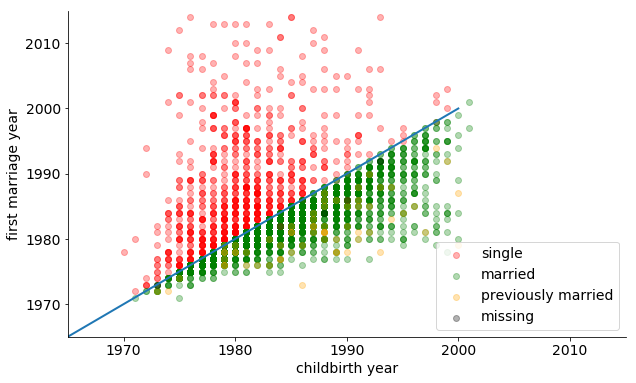

In [22]:
# plot prebirth month and marriage start year
married_df = merged[merged.yrbg1m_xrnd > 0]
plt.scatter(married_df[married_df.marstat==0].childbirth_year, married_df[married_df.marstat==0].yrbg1m_xrnd, 
            alpha=0.3, label='single', c='red')
plt.scatter(married_df[married_df.marstat==1].childbirth_year, married_df[married_df.marstat==1].yrbg1m_xrnd, 
            alpha=0.3, label='married', c='green')
plt.scatter(married_df[married_df.marstat==2].childbirth_year, married_df[married_df.marstat==2].yrbg1m_xrnd, 
            alpha=0.3, label='previously married', c='orange')
plt.scatter(married_df[married_df.marstat.isnull()].childbirth_year, married_df[married_df.marstat.isnull()].yrbg1m_xrnd, 
            alpha=0.3, label='missing', c='black')
plt.xlim([1965, 2015])
plt.ylim([1965, 2015])
plt.plot([1965, 2000], [1965, 2000])
plt.legend()
plt.xlabel('childbirth year')
plt.ylabel('first marriage year')
remove_border()

## Mothers' employment status

Variables Used/considered:

* fam_7: WITH WHOM DID R LIVE AT AGE 14?
    * 11 FATHER-MOTHER
    * 12 FATHER-STEPMOTHER
    * 21 STEPFATHER-MOTHER
    * 22 STEPFATHER-STEPMOTHER
    * 31 MAN RELATIVE-MOTHER
    * 32 MAN RELATIVE-STEPMOTHER
    * 41 OTHER MAN-MOTHER
    * 42 OTHER MAN-STEPMOTHER
    * 51 NO MAN-MOTHER
    * 52 NO MAN-STEPMOTHER
    * 91 MISSING MAN-MOTHER

* fam_8: RELATION TO R OF ADULT FEMALE IN HOUSEHOLD AT AGE 14
    * not usable, a lot of valid skips
       
* fam_9: DID ADULT FEMALE PRESENT IN HOUSEHOLD AT AGE 14 WORK FOR PAY?
    * 1 YES
    * 0 NO

In [23]:
mother_df = pd.read_csv('../data/mother.csv')
mother_df.head()

,caseid_1979,fam_7_1979,fam_8_1979,fam_9_1979,hgc_mother_1979,fam_19_1979,fam_19c_1979
0,1,11,-4,0,8,2,1
1,2,11,-4,0,5,3,-4
2,3,21,-4,1,10,1,2
3,4,21,-4,1,11,1,2
4,5,11,-4,1,12,1,1


In [24]:
merged = iv_df.merge(mother_df, on='caseid_1979')
merged.fam_7_1979.unique()

array([11, 21, 51, 80, 15, 31, 33, 91, 44, 41, 54, 55, 12, 53, 13, 35, -3,
       90, 45, 42, 19, 43, 22, 14])

In [25]:
def has_mom_fig(x):
    """
    Return whether R had mother/stepmothre figure, that is, 
    the variable fam_7 returns the following values: 
    * 11 FATHER-MOTHER
    * 12 FATHER-STEPMOTHER
    * 21 STEPFATHER-MOTHER
    * 22 STEPFATHER-STEPMOTHER
    * 31 MAN RELATIVE-MOTHER
    * 32 MAN RELATIVE-STEPMOTHER
    * 41 OTHER MAN-MOTHER
    * 42 OTHER MAN-STEPMOTHER
    * 51 NO MAN-MOTHER
    * 52 NO MAN-STEPMOTHER
    * 91 MISSING MAN-MOTHER
    """
    
    return x in [11, 12, 21, 22, 31, 32, 41, 42, 51, 52, 91]

merged['has_mom'] = merged.fam_7_1979.map(has_mom_fig)
merged.has_mom.value_counts()

True     3454
False     234
Name: has_mom, dtype: int64

In [26]:
merged.fam_9_1979.value_counts()

 1    1940
 0    1665
-4      58
-3      22
-2       3
Name: fam_9_1979, dtype: int64

In [27]:
def mom_worked(row):
    """
    Return whether mother figure (mother/stepmother) worked when R was at age 14. 
    """
    
    if row['has_mom']:
        if row['fam_9_1979'] == 1:
            return 1
        elif row['fam_9_1979'] == 0:
            return 0
    else:
        return 2 # no mother figure
    return None # catch missing

merged['mom_worked'] = merged.apply(mom_worked, axis=1)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,fam_7_1979,fam_8_1979,fam_9_1979,hgc_mother_1979,fam_19_1979,fam_19c_1979,has_mom,mom_worked
0,2,1993,3,1959,1,3,34,2,1.0,11,-4,0,5,3,-4,True,0.0
1,3,1981,6,1961,8,3,19,1,1.0,21,-4,1,10,1,2,True,1.0
2,4,1980,8,1962,8,3,17,1,0.0,21,-4,1,11,1,2,True,1.0
3,8,1976,3,1958,7,3,17,1,1.0,11,-4,1,9,1,1,True,1.0
4,16,1990,2,1958,10,3,31,3,1.0,11,-4,0,12,1,1,True,0.0


In [28]:
# merge 
iv_df = iv_df.merge(merged[['caseid_1979', 'mom_worked']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,mom_worked
0,2,1993,3,1959,1,3,34,2,1.0,0.0
1,3,1981,6,1961,8,3,19,1,1.0,1.0
2,4,1980,8,1962,8,3,17,1,0.0,1.0
3,8,1976,3,1958,7,3,17,1,1.0,1.0
4,16,1990,2,1958,10,3,31,3,1.0,0.0


In [29]:
iv_df.mom_worked.value_counts(dropna=False)

 1.0    1868
 0.0    1571
 2.0     234
NaN       15
Name: mom_worked, dtype: int64

## Mothers' Education

In [30]:
# Respondents who reported no mother figure in the mother's employment question
# differ from those who reproted no mother figure in the mother's education question 

pd.crosstab(merged.has_mom, merged.hgc_mother_1979)

hgc_mother_1979,-4,-3,-2,-1,0,1,2,3,4,5,...,11,12,13,14,15,16,17,18,19,20
has_mom,,,,,,,,,,,,,,,,,,,,,
False,1,11,40,0,3,2,0,2,7,7,...,24,63,4,6,1,1,2,0,0,0
True,1,71,102,1,38,9,23,74,63,66,...,338,1245,97,141,30,154,26,18,2,3


In [31]:
def get_ma_educ(row):
    """
    Given respondent data row, return highest grade achieved by R's mother. 
    
    If R had no mother figure, code ma educ to category, not missing. 
    If R knew mother and invalid ma educ, set to missing.
    
    Value scheme:
    0 - no mother figure
    1 - less than high school
    2 - high school
    3 - some college
    4 - college
    5 - higher than college
    """
      
    if row['has_mom']:
        g = row['hgc_mother_1979'] # grade

        if g >= 0 and g<12:
            return 1

        elif g==12:
            return 2

        elif (g>12 and g<16):
            return 3

        elif g==16:
            return 4

        elif (g>16 and g<95):
            return 5
    
    else:
        return 0 # no mother figure

    return None # capture missing


merged['mom_educ'] = merged.apply(get_ma_educ, axis=1)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,fam_7_1979,fam_8_1979,fam_9_1979,hgc_mother_1979,fam_19_1979,fam_19c_1979,has_mom,mom_worked,mom_educ
0,2,1993,3,1959,1,3,34,2,1.0,11,-4,0,5,3,-4,True,0.0,1.0
1,3,1981,6,1961,8,3,19,1,1.0,21,-4,1,10,1,2,True,1.0,1.0
2,4,1980,8,1962,8,3,17,1,0.0,21,-4,1,11,1,2,True,1.0,1.0
3,8,1976,3,1958,7,3,17,1,1.0,11,-4,1,9,1,1,True,1.0,1.0
4,16,1990,2,1958,10,3,31,3,1.0,11,-4,0,12,1,1,True,0.0,2.0


In [32]:
def get_ma_grade(row):
    """
    Given respondent data row, return highest grade achieved by R's mother. 
    
    If R had no mother figure, code ma educ to category, not missing. 
    If R knew mother and invalid ma educ, set to missing.

    Return grade, not educ categories. 
    """
      
    if row['has_mom']:
        g = row['hgc_mother_1979'] # grade

        if g >= 0 and g < 95: # checked, no 95
            return g
    
    else:
        return None # no mother figure
    
    return None

merged['mom_grade'] = merged.apply(get_ma_grade, axis=1)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,fam_7_1979,fam_8_1979,fam_9_1979,hgc_mother_1979,fam_19_1979,fam_19c_1979,has_mom,mom_worked,mom_educ,mom_grade
0,2,1993,3,1959,1,3,34,2,1.0,11,-4,0,5,3,-4,True,0.0,1.0,5.0
1,3,1981,6,1961,8,3,19,1,1.0,21,-4,1,10,1,2,True,1.0,1.0,10.0
2,4,1980,8,1962,8,3,17,1,0.0,21,-4,1,11,1,2,True,1.0,1.0,11.0
3,8,1976,3,1958,7,3,17,1,1.0,11,-4,1,9,1,1,True,1.0,1.0,9.0
4,16,1990,2,1958,10,3,31,3,1.0,11,-4,0,12,1,1,True,0.0,2.0,12.0


In [33]:
# merge 
iv_df = iv_df.merge(merged[['caseid_1979', 'mom_educ', 'mom_grade']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,mom_worked,mom_educ,mom_grade
0,2,1993,3,1959,1,3,34,2,1.0,0.0,1.0,5.0
1,3,1981,6,1961,8,3,19,1,1.0,1.0,1.0,10.0
2,4,1980,8,1962,8,3,17,1,0.0,1.0,1.0,11.0
3,8,1976,3,1958,7,3,17,1,1.0,1.0,1.0,9.0
4,16,1990,2,1958,10,3,31,3,1.0,0.0,2.0,12.0


In [34]:
iv_df.mom_educ.value_counts(dropna=False)

 1.0    1563
 2.0    1245
 3.0     268
 0.0     234
NaN      175
 4.0     154
 5.0      49
Name: mom_educ, dtype: int64

In [35]:
iv_df.mom_grade.value_counts(dropna=False)

 12.0    1245
NaN       409
 11.0     338
 10.0     320
 8.0      225
 9.0      196
 16.0     154
 14.0     141
 6.0      131
 13.0      97
 7.0       80
 3.0       74
 5.0       66
 4.0       63
 0.0       38
 15.0      30
 17.0      26
 2.0       23
 18.0      18
 1.0        9
 20.0       3
 19.0       2
Name: mom_grade, dtype: int64

## OTHER DESCRIPTIVE STATISTICS

## Total fertility

In [36]:
analytic_df.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd', u'c4dob_m_xrnd',
       u'c4dob_y_xrnd', u'c5dob_m_xrnd', u'c5dob_y_xrnd', u'c6dob_m_xrnd',
       u'c6dob_y_xrnd', u'c7dob_m_xrnd', u'c7dob_y_xrnd', u'c8dob_m_xrnd',
       u'c8dob_y_xrnd', u'c9dob_m_xrnd', u'c9dob_y_xrnd', u'c10dob_m_xrnd',
       u'c10dob_y_xrnd', u'c11dob_m_xrnd', u'c11dob_y_xrnd', u'y_dob',
       u'm_dob', u'date_m_1979', u'date_d_1979', u'date_m_1980',
       u'date_d_1980', u'date_m_1981', u'date_d_1981', u'date_m_1982',
       u'date_d_1982', u'date_m_1983', u'date_d_1983', u'date_m_1984',
       u'date_d_1984', u'date_m_1985', u'date_d_1985', u'date_m_1986',
       u'date_d_1986', u'date_m_1987', u'date_d_1987', u'date_m_1988',
       u'date_d_1988', u'date_m_1989', u'date_d_1989', u'date_m_1990',
       u'date_d_1990', u'date_m_1991', u'date_d_1991', u'date_m_199

In [37]:
def get_num_child(i):
    row = analytic_df[analytic_df.caseid_1979==i].iloc[0]
    vals = [row['c%sdob_y_xrnd'%j] != -4 for j in range(1, 12)] # if not valid skip, then it's a birth
    return sum(vals)
  
iv_df['numchild'] = iv_df.caseid_1979.map(get_num_child)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,mom_worked,mom_educ,mom_grade,numchild
0,2,1993,3,1959,1,3,34,2,1.0,0.0,1.0,5.0,2
1,3,1981,6,1961,8,3,19,1,1.0,1.0,1.0,10.0,3
2,4,1980,8,1962,8,3,17,1,0.0,1.0,1.0,11.0,2
3,8,1976,3,1958,7,3,17,1,1.0,1.0,1.0,9.0,3
4,16,1990,2,1958,10,3,31,3,1.0,0.0,2.0,12.0,3


## Time between first and second birth

Assume that the child was born at the end of the month.

In [38]:
def get_time(i):
    """
    Return number of months between first childbirth and second childbirth. 
    Return None if no second child.
    """
    
    row = analytic_df[analytic_df.caseid_1979==i].iloc[0]

    if row['c2dob_y_xrnd']>0 and row['c2dob_m_xrnd']>0:
        return diff_month(datetime(row['c2dob_y_xrnd'], row['c2dob_m_xrnd'], 1), 
                          datetime(row['c1dob_y_xrnd'], row['c1dob_m_xrnd'], 1)) 
    else:
        return None  #only one child, NA
        

iv_df['time_btw_birth'] = iv_df.caseid_1979.map(get_time)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,mom_worked,mom_educ,mom_grade,numchild,time_btw_birth
0,2,1993,3,1959,1,3,34,2,1.0,0.0,1.0,5.0,2,20.0
1,3,1981,6,1961,8,3,19,1,1.0,1.0,1.0,10.0,3,28.0
2,4,1980,8,1962,8,3,17,1,0.0,1.0,1.0,11.0,2,199.0
3,8,1976,3,1958,7,3,17,1,1.0,1.0,1.0,9.0,3,38.0
4,16,1990,2,1958,10,3,31,3,1.0,0.0,2.0,12.0,3,42.0


In [39]:
sum(iv_df.time_btw_birth.isnull()) # how many have only one child

673

## Count months of each status

In [40]:
monthly_df = pd.read_csv('../data/monthly_df_seq14.csv')
monthly_df.head()

,caseid_1979,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month159,month160,month161,month162,month163,month164,month165,month166,month167,month168
0,2,1993,4,8,1,6,6,6,6,6,...,3,3,3,3,3,3,3,3,3,3
1,3,1981,7,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2,8,1976,4,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,16,1990,3,1,1,8,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,19,1987,12,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [41]:
def count_status(row, s):
    counts = [row['month%s'%i]==s for i in range(1, 169)]
    return sum(counts)


monthly_df['num_ft'] = monthly_df.apply(lambda row: count_status(row, 1), axis=1)
monthly_df['num_pt1'] = monthly_df.apply(lambda row: count_status(row, 2), axis=1)
monthly_df['num_pt2'] = monthly_df.apply(lambda row: count_status(row, 3), axis=1)
monthly_df['num_work_miss_hr'] = monthly_df.apply(lambda row: count_status(row, 4), axis=1)
monthly_df['num_unemp'] = monthly_df.apply(lambda row: count_status(row, 5), axis=1)
monthly_df['num_oolf'] = monthly_df.apply(lambda row: count_status(row, 6), axis=1)
monthly_df['num_nonwork'] = monthly_df.apply(lambda row: count_status(row, 7), axis=1)
monthly_df['num_gaps'] = monthly_df.apply(lambda row: count_status(row, 8), axis=1)
monthly_df['num_miss'] = monthly_df.apply(lambda row: count_status(row, 0), axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_ft', 'num_pt1', 'num_pt2', 'num_work_miss_hr', 'num_unemp', 'num_oolf', 'num_nonwork', 'num_gaps', 'num_miss']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,mom_worked,...,time_btw_birth,num_ft,num_pt1,num_pt2,num_work_miss_hr,num_unemp,num_oolf,num_nonwork,num_gaps,num_miss
0,2,1993,3,1959,1,3,34,2,1.0,0.0,...,20.0,1,0,43,0,25,98,0,1,0
1,3,1981,6,1961,8,3,19,1,1.0,1.0,...,28.0,37,6,0,0,14,107,0,4,0
2,4,1980,8,1962,8,3,17,1,0.0,1.0,...,199.0,86,4,0,0,12,61,0,5,0
3,8,1976,3,1958,7,3,17,1,1.0,1.0,...,38.0,90,3,2,0,11,15,1,25,21
4,16,1990,2,1958,10,3,31,3,1.0,0.0,...,42.0,41,67,50,0,0,0,0,10,0


## number of unemployed spells longer than 3 months

In [42]:
# for example, look at one respondent in the second row
row = monthly_df.iloc[1]

counts = [str(int(row['month%s'%i] in [5, 6, 7])) for i in range(1, 169)] # convert unemployed months to 1, other months to 0
s = ''.join(counts) # combine into a string
unemployed_spells = s.split('0') # cut by 0
print unemployed_spells
unemployed_spells_counts = [spell for spell in unemployed_spells if len(spell) >= 3] # only include unemployed spells >= 3 months
print len(unemployed_spells_counts)

['111111111111111111111111111111111', '', '', '', '', '', '111111111111111111111', '', '', '', '', '', '', '1111111111', '', '', '', '1111111111', '', '', '', '', '', '', '', '', '', '11111111111111111', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '111111111111111111111111111111']
6


In [43]:
def count_spells(row):
    
    # convert unemployed months to 1, others to 0. then combine into a string
    counts = [str(int(row['month%s'%i] in [5, 6, 7])) for i in range(1, 169)]
    s = ''.join(counts)
    
    unemployed_spells = s.split('0')
    unemployed_spells_counts = [spell for spell in unemployed_spells if len(spell) >= 3] # only include unemployed spells >= 3 months
    return len(unemployed_spells_counts)


monthly_df['num_nonemp_spells'] = monthly_df.apply(count_spells, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_nonemp_spells']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,race,age,educ,marstat,mom_worked,...,num_ft,num_pt1,num_pt2,num_work_miss_hr,num_unemp,num_oolf,num_nonwork,num_gaps,num_miss,num_nonemp_spells
0,2,1993,3,1959,1,3,34,2,1.0,0.0,...,1,0,43,0,25,98,0,1,0,1
1,3,1981,6,1961,8,3,19,1,1.0,1.0,...,37,6,0,0,14,107,0,4,0,6
2,4,1980,8,1962,8,3,17,1,0.0,1.0,...,86,4,0,0,12,61,0,5,0,4
3,8,1976,3,1958,7,3,17,1,1.0,1.0,...,90,3,2,0,11,15,1,25,21,3
4,16,1990,2,1958,10,3,31,3,1.0,0.0,...,41,67,50,0,0,0,0,10,0,0


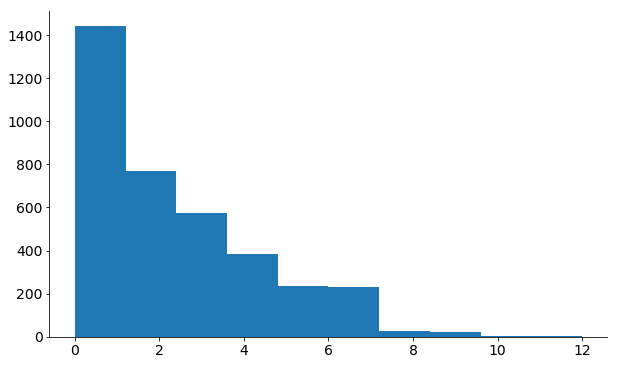

In [44]:
plt.hist(iv_df.num_nonemp_spells)
remove_border()

In [45]:
# export to csv
iv_df.to_csv('../data/iv_df_seq14.csv', index=False)